# Detecting the Milky Way on 2024/05/31!!!

Load the observations from that night.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# for logging
from time import time
import logging

# to save output data and parameters
from datetime import datetime
import yaml
import os

# If running outside of the rtlobs github repo,
# add path
import sys
sys.path.append('/home/stellarmate/rtlobs')
from rtlobs import collect as col
from rtlobs import post_process as post
from rtlobs import utils as ut

In [2]:
############################################################
# 21cm rest-frame frequency
nu21cm = 1420405751.768 # [Hz]

# Exposure parameters
param = {}
param['nSample'] = 8192 # samples per call to the SDR, to avoid loading too much in RAM
param['nBin'] = 512   #1024   #2048   # number of freq bins for  power spectrum 
param['gain'] = 49.6 # [dB] of RtlSdr gain
param['sampleRate'] = 2.32e6   #3.2e6  # [Hz] sample rate of the SDR, which determines bandwidth of spectrum
param['centerFrequency'] = nu21cm # [GHz] center frequency
param['integrationTime'] = 5*60  #5 * 60  # [sec] integration time

# Frequency shifting parameters
#throwFrequency = nu21cm + 1.e6 # [Hz] alternate frequency. The freq diff has to be less than achieved bandwidth
frequencyShift = 2.5e6   # freq offset between fiducial and shifted frequencies [Hz]
param['throwFrequency'] = nu21cm + frequencyShift # [Hz] alternate frequency. The freq diff has to be less than achieved bandwidth
# Too bad, I would like a shift of 3.e6 Hz for my 21cm line...
param['alternatingFrequency'] = 1.   # [Hz] frequency at which we switch between fiducial and shifted freqs


# create header for output file to log these parameters
headerOutputFile =  "Exposure settings:\n"
headerOutputFile += "nSample = "+str(param['nSample'])+" # samples per call to the SDR\n"
headerOutputFile += "nBin = "+str(param['nBin'])+" # bin resolution power spectrum \n"
headerOutputFile += "gain = "+str(param['gain'])+" # [dB] of RtlSdr gain\n"
headerOutputFile += "sample rate = "+str(param['sampleRate'])+" # [Hz] controls bandwidth\n"
headerOutputFile += "centerFrequency = "+str(param['centerFrequency'])+" # [Hz] center frequency\n"
headerOutputFile += "integrationTime = "+str(param['integrationTime'])+" # [sec] integration time\n"
headerOutputFile += "alternateFrequency = "+str(param['throwFrequency'])+" # [Hz] alternate frequency\n"
headerOutputFile += "alternatingFrequency = "+str(param['alternatingFrequency'])+" # [Hz] alternating frequency\n"


#################################################################
# Create output and figure folders

# get today's date as yyyymmdd
param['dateCapture'] = "20240531"

# Output path
pathOut = "./output/"+param['dateCapture']
if not os.path.exists(pathOut):
   os.makedirs(pathOut)

# Figures path
pathFig = "./figures/"+param['dateCapture']
if not os.path.exists(pathFig):
   os.makedirs(pathFig)

In [3]:
#################################################################
# read all 'reduced' exposures into array

def list_files_reduced(directory):
   # list all files in directory
   files = os.listdir(directory)

   # filter to keep only those starting with the prefix
   matching_files = [file for file in files if file.endswith('reduced.txt')]

   return matching_files


filesReduced = list_files_reduced(pathOut)


         #headerOutputFileFinal += 'foff, poff, fon, pon, foff, poff, pBase, pDiffBase, pDiffBaseSmart\n'
dataReduced = np.zeros((len(filesReduced), param['nBin'], 9))
for iFile in range(len(filesReduced)):
   file = filesReduced[iFile]
   dataReduced[iFile, :, :] = np.loadtxt(pathOut + '/' + file)

# parse the low and high exposures
pHigh = np.zeros_like(dataReduced[:,:,0])
pLow = np.zeros_like(pHigh)
for iFile in range(len(filesReduced)):
    if dataReduced[iFile,0,0] < dataReduced[iFile,0,4]:
        fLow = dataReduced[iFile,:,0]
        pLow[iFile,:] = dataReduced[iFile,:,1]
        fHigh = dataReduced[iFile,:,4]
        pHigh[iFile,:] = dataReduced[iFile,:,5]
    else:
        fHigh = dataReduced[iFile,:,0]
        pHigh[iFile,:] = dataReduced[iFile,:,1]
        fLow = dataReduced[iFile,:,4]
        pLow[iFile,:] = dataReduced[iFile,:,5]       

fOn = dataReduced[0,:,2]
pOn = dataReduced[:,:,3]
pBase = dataReduced[:,:,6]
pSub = pOn - pBase
pCalib = pOn / pBase - 1
pSub = pOn - pBase
pOnMean = np.mean(pOn, axis=0)
pOnMin = np.min(pOn, axis=0)
pBaseMean = np.mean(pBase, axis=0)
pCalibMean = np.mean(pCalib, axis=0)
pSubMean = np.mean(pSub, axis=0)
#
pCalibRenorm = np.zeros_like(pCalib)
for iFile in range(len(filesReduced)):
   pCalibRenorm[iFile,:] = pCalib[iFile,:] / pCalib[iFile, param['nBin']//2]

In [16]:
def basePlot():
    fig=plt.figure(0)
    ax=fig.add_subplot(111)
    #
    ax.axvline(0., c='k', label=r'$\nu^0_\text{21cm}$')
    #
    # f = (fOn[I] - nu21cm) / 1.e6 # [MHz]
    # p = pOn[iFile,I] / pOnMeanNoMW[I] - 1.
    # ax.plot(f, p, '--', label=r'truncated')
    #
    # Add alternate x axis showing velocities
    ax2 = ax.twiny()
    c = 299792458.e-3  # speed of light [km/s]
    ax2.set_xticks(ax.get_xticks())
    ax2.set_xticklabels( np.round(ax.get_xticks()*1.e6/nu21cm * c, 1))
    ax2.set_xlabel(r'$v_\text{LOS}$ [km/s]')
    #
    ax.legend(loc=2)
    ax.set_xlabel(r'$\nu - \nu^0_\text{21cm}$ [MHz]')
    ax.set_ylabel(r'Uncalibrated intensity [au]')

    return fig, ax, ax2

# Raw exposures at the fiducial frequency throughout the night

The ON exposures show large RFI spikes.
They also show a coherent up and down variation at all frequencies, over time.
Presumably due to thermal variations in the antenna and receiver electronics through the night.

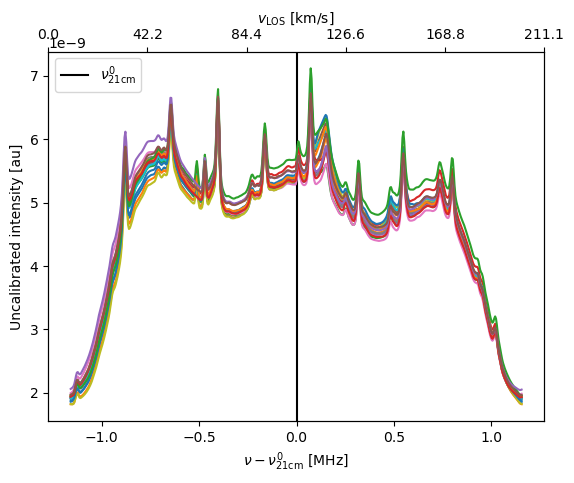

In [17]:
fig, ax, ax2 = basePlot()
#
for iFile in range(len(filesReduced)):
   ax.plot((fOn-nu21cm) / 1.e6, pOn[iFile,:])

plt.show()

# The mean of exposures away from the MW provides a useful baseline: it removes amplifier ripples and RFI

Dividing by the min or the mean of the ON exposures does a very good job at removing the RFI.
This means the RFI amplitudes must not have evolved over time.
The fat that the telescope did not move in alt-az probably helped (drift scan mode).
This may not remain true if the telescope is moved to look at different patches of sky.

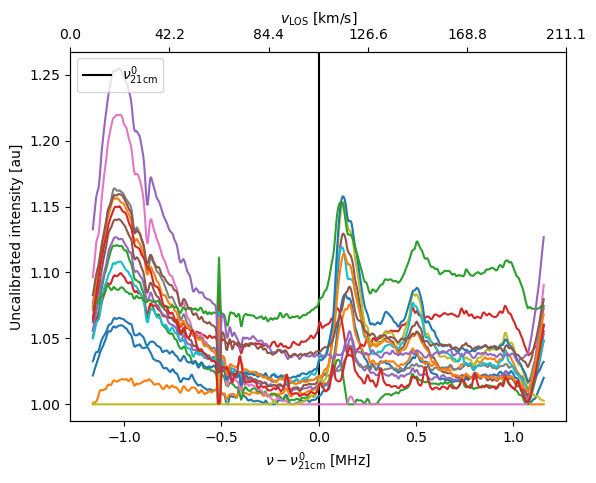

In [40]:
fig, ax, ax2 = basePlot()
#
for iFile in range(len(filesReduced)):
   ax.plot((fOn-nu21cm) / 1.e6, pOn[iFile,:] / np.min(pOn, axis=0))

plt.show()

# Detection of the Milky Way!!!

Some of my exposures were taken at a time when the Milky Way was not within the beam (dashed lines).
I can use the mean of these exposures as a baseline for all exposures.
Some exposures were taken at a time when the Milky Way should be within the beam (solid lines).
Using the baseline above, a clear 21cm line is seen!
There is also a smooth residual baseline offset, which evolves over time.
Presumably, this residual baseline can be subtracted off with a 2nd order polynomial.

In [28]:
# Exposures close to 5am likely had the MW in them,
# the others did not.
# Here are file numbers that were away/on the MW
IFileOnMW = [2, 3, 6]
IFileOffMW = [5, 8, 10, 11]

In [29]:
# Baseline estimate:
# compute the mean signal across the exposures for which I am sure 
# they were not on the MW, based on time
# ie far from 5am when the MW transited.
pOnMeanNoMW = np.zeros_like(fOn)
for iFile in IFileNoMW:
   pOnMeanNoMW += pOn[iFile,:]/3.

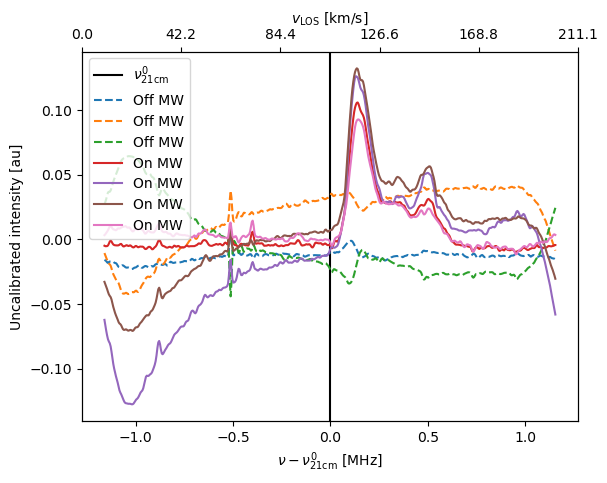

In [37]:
fig, ax, ax2 = basePlot()
#
for iFile in IFileOnMW:
   ax.plot((fOn - nu21cm) / 1.e6, pOn[iFile,:] / pOnMeanNoMW - 1., '--', label='Off MW')
#
# exposures for which I expect high MW based on time (close to 5am)
for iFile in IFileOffMW:
   ax.plot((fOn - nu21cm) / 1.e6, pOn[iFile,:] / pOnMeanNoMW - 1., label='On MW')
#
ax.legend(loc=2)

plt.show()

# Truncation and polynomial residual baseline fitting 

Focus on one of the exposures on the Milky Way.

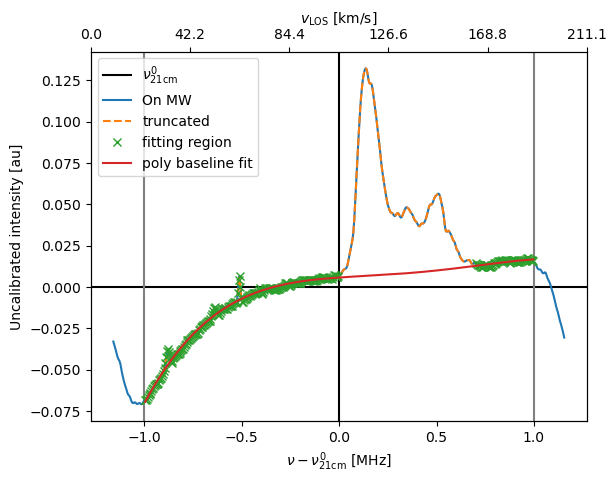

In [35]:
fig, ax, ax2 = basePlot()
#
ax.axhline(0., c='k')
#
# truncation frequencies
dnuMin = -1.e6 # [Hz]
dnuMax = 1.e6 # [Hz]
ax.axvline(dnuMin / 1.e6, c='gray')
ax.axvline(dnuMax / 1.e6, c='gray')
#
# Pick one exposure on the MW
iFile = 10
ax.plot((fOn - nu21cm) / 1.e6, pOn[iFile,:] / pOnMeanNoMW - 1., label='On MW')
#
# Truncated exposure
I = np.where( (fOn - nu21cm > dnuMin) * (fOn - nu21cm < dnuMax))[0]
f = (fOn[I] - nu21cm) / 1.e6 # [MHz]
p = pOn[iFile,I] / pOnMeanNoMW[I] - 1.
ax.plot(f, p, '--', label=r'truncated')
#
# Fitting region for the polynomial
J = np.where( (f<0)+(f>0.7) )[0]
ax.plot(f[J], p[J], 'x', label=r'fitting region')
#
# fit polynomial and subtract
polyCoeff = np.polyfit(f[J], p[J], 4)
polyBaseline = np.poly1d(polyCoeff)(f)
ax.plot(f, polyBaseline, label=r'poly baseline fit')
#
ax.legend(loc=2)

Corresponding baseline-subtracted spectrum!

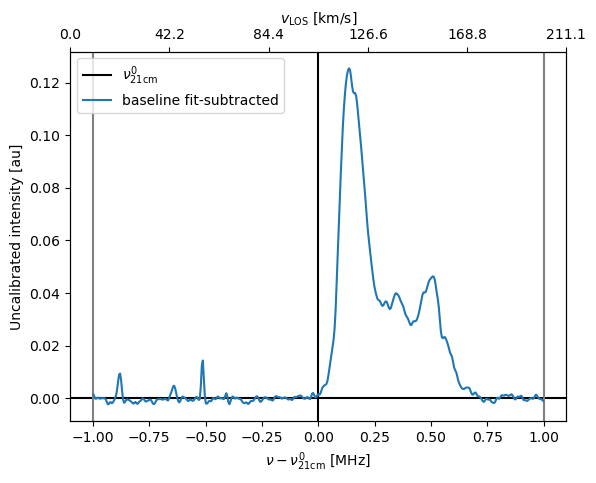

In [36]:
fig, ax, ax2 = basePlot()
#
ax.axhline(0., c='k')
#
# truncation frequencies
dnuMin = -1.e6 # [Hz]
dnuMax = 1.e6 # [Hz]
ax.axvline(dnuMin / 1.e6, c='gray')
ax.axvline(dnuMax / 1.e6, c='gray')
#
pClean = p - polyBaseline
ax.plot(f, pClean, label=r'baseline fit-subtracted')
#
ax.legend(loc=2)

plt.show()

# Fit as a linear combination of Gaussian

In [43]:
from scipy.optimize import curve_fit

In [44]:
def gaussian(x, a, mu, s2):
    return a * np.exp(-0.5 * (x-mu)**2/ s2) / np.sqrt(2*np.pi*s2)

def gaussianMixture(x, *params):
    '''params = [a1, ..., an, mu1, ..., mun, s21, ..., s2n]
    '''
    nComponents = len(params) // 3
    result = np.zeros_like(x)
    for i in range(nComponents):
        a = params[i]
        mu = params[nComponents + i]
        s2 = params[2 * nComponents + i]
        result += gaussian(x, a, mu, s2)
    return result

In [76]:
# Initial guess for parameters
nComponents = 4

In [77]:
initial_guess = [1.e-2 for i in range(nComponents)] # amplitudes
initial_guess += [1.e-1 for i in range(nComponents)] # means [MHz]
initial_guess += [1.e-2 for i in range(nComponents)] # variances [MHz^2]

minList = [0. for i in range(nComponents)]
minList += [-np.inf for i in range(nComponents)]
minList += [0. for i in range(nComponents)]

maxList = [np.inf for i in range(len(initial_guess))]
bounds = (minList, maxList)

# restrict the fit to avoid the RFI
J = np.where(f>-0.5)[0]
# Fit the model to the data
params, cov = curve_fit(gaussianMixture, f[J], pClean[J], p0=initial_guess, bounds=bounds, maxfev=int(1e5))

print('Best-fit:')
print('- Amplitudes:'+str(params[:nComponents]))
print('- Means [MHz]:'+str(params[nComponents:2*nComponents]))
print('- sigmas [MHz]:'+str(params[2*nComponents:]))


Best-fit:
- Amplitudes:[0.00121896 0.00455136 0.00928502 0.01378078]
- Means [MHz]:[0.500839   0.51066645 0.30161423 0.14517896]
- sigmas [MHz]:[0.00078604 0.00549977 0.00978227 0.00219393]


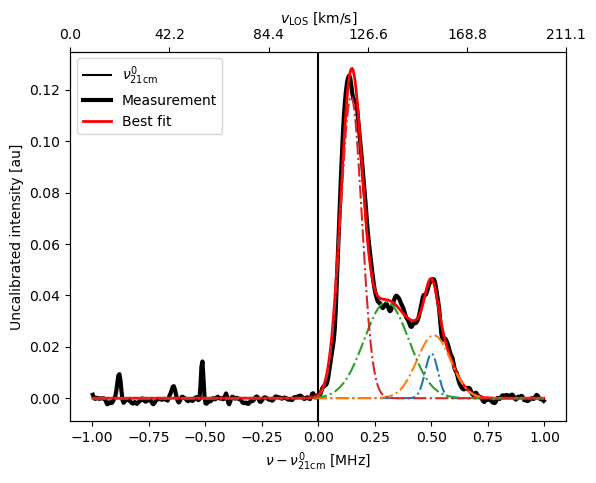

In [78]:
fig, ax, ax2 = basePlot()
#
ax.plot(f, pClean, 'k', lw=3, label='Measurement')
ax.plot(f, gaussianMixture(f, *params), 'r', lw=2, label='Best fit')
ax.legend(loc=2)
#
for i in range(nComponents):
    a = params[i]
    mu = params[nComponents + i]
    s2 = params[2 * nComponents + i]
    ax.plot(f, gaussian(f, *[a, mu, s2]), '-.')

plt.show()

Change the fit to first identify the peaks, then only allow to vary the amplitudes and the widths of Gaussians centered around the peaks.

In [ ]:
from scipy.signal import find_peaks

In [107]:
# Find peaks
prominenceThreshold = 3
plateauSize = 3
width = 5
height = 0.02
distance = 10
# IPeak, _ = find_peaks(pClean, height=height, distance=distance, width=width)
IPeak, _ = find_peaks(pClean, height=height, width=width)

# Peaks contains the indices of the local maxima
# You can get their corresponding x and y values
fPeaks = f[IPeak]
pPeaks = pClean[IPeak]

# Example usage to print the locations of the peaks
for x_peak, y_peak in zip(fPeaks, pPeaks):
    print("Peak at x =", x_peak, "y =", y_peak)

Peak at x = 0.1359375 y = 0.12546794689920082
Peak at x = 0.344375 y = 0.03990627674795632
Peak at x = 0.5075 y = 0.04633081062618617


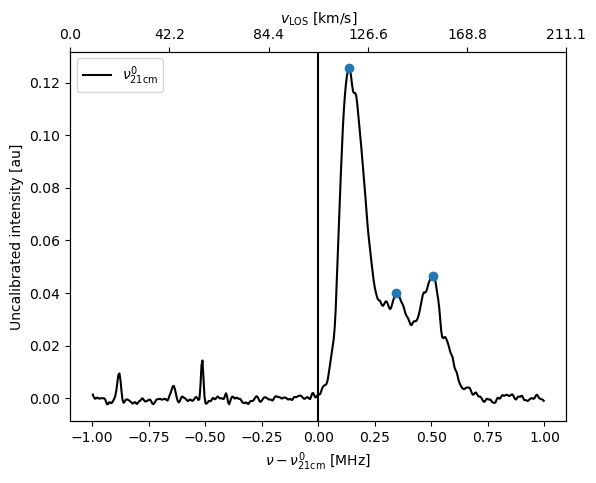

In [119]:
fig, ax, ax2 = basePlot()
#
ax.plot(f, pClean, 'k', label='Measurement')
#
ax.plot(fPeaks, pPeaks, 'o')

plt.show()

In [120]:
def gaussianMix(x, *params):
    '''params = [a1, ..., an, s21, ..., s2n]
    '''
    nComponents = len(params) // 2
    result = np.zeros_like(x)
    for i in range(nComponents):
        a = params[i]
        mu = fPeaks[i]
        s2 = params[nComponents + i]
        result += gaussian(x, a, mu, s2)
    return result

In [121]:
nComponents = len(fPeaks)

initial_guess = [1.e-2 for i in range(nComponents)] # amplitudes
initial_guess += [1.e-2 for i in range(nComponents)] # variances [MHz^2]

minList = [0. for i in range(nComponents)]
minList += [0. for i in range(nComponents)]
maxList = [np.inf for i in range(len(initial_guess))]
bounds = (minList, maxList)

# restrict the fit to avoid the RFI
J = np.where(f>-0.5)[0]
# Fit the model to the data
params, cov = curve_fit(gaussianMix, f[J], pClean[J], p0=initial_guess, bounds=bounds, maxfev=int(1e5))

print('Best-fit:')
print('- Amplitudes:'+str(params[:nComponents]))
print('- sigmas [MHz]:'+str(params[nComponents:]))


Best-fit:
- Amplitudes:[0.01286213 0.01446217 0.00200759]
- sigmas [MHz]:[0.00212055 0.0209359  0.00106652]


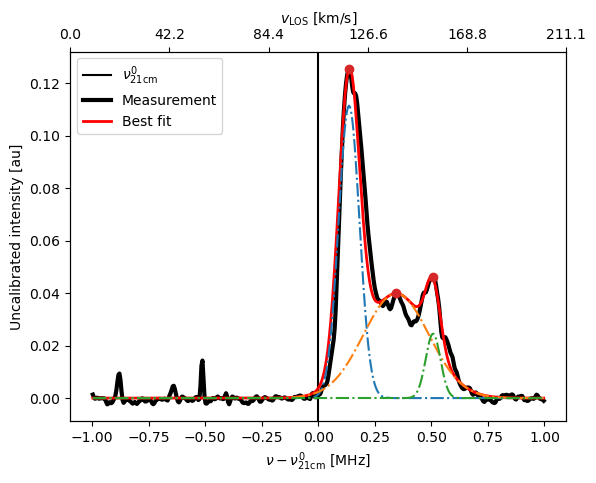

In [122]:
fig, ax, ax2 = basePlot()
#
ax.plot(f, pClean, 'k', lw=3, label='Measurement')
ax.plot(f, gaussianMix(f, *params), 'r', lw=2, label='Best fit')
ax.legend(loc=2)
#
for i in range(nComponents):
    a = params[i]
    mu = fPeaks[i]
    s2 = params[nComponents + i]
    ax.plot(f, gaussian(f, a, mu, s2), '-.')
#
ax.plot(fPeaks, pPeaks, 'o')

plt.show()

# Frequency shifting fails to remove amplifier ripple and RFI

Do the frequency switched exposures help?
The exposures at higher frequency (dashed) have a very different broad shape from the fiducial exposures.
The exposures at lower frequency (dot-dashed) have a more similar broad shape.
But both low and high frequency exposures have RFI spikes at the wrong places.
They are thus useless in removing the RFI.

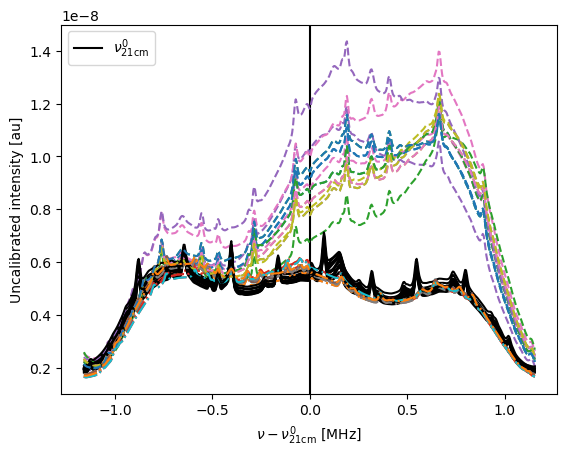

In [39]:
fig=plt.figure(0)
ax=fig.add_subplot(111)
#
ax.axvline(0., c='k', label=r'$\nu^0_\text{21cm}$')
#
for iFile in range(len(filesReduced)):
   ax.plot((fOn - nu21cm) / 1.e6, pOn[iFile,:], 'k-')
   ax.plot((fOn - nu21cm) / 1.e6, pLow[iFile,:], '--')
   ax.plot((fOn - nu21cm) / 1.e6, pHigh[iFile,:], '-.')
#
ax.legend(loc=2)
ax.set_xlabel(r'$\nu - \nu^0_\text{21cm}$ [MHz]')
ax.set_ylabel(r'Uncalibrated intensity [au]')
plt.show()

Indeed, normalizing the fiducial exposures with the low or high exposures does not help remove the RFI spikes.
The low frequency observations do a decent job at removing the broad amplifier ripple shape, but not better than using the mean of exposures away from the Milky Way.
The frequency shifted exposures thus do not seem to help.
Since they are costly in terms of observing time, I might as well omit them in the future.

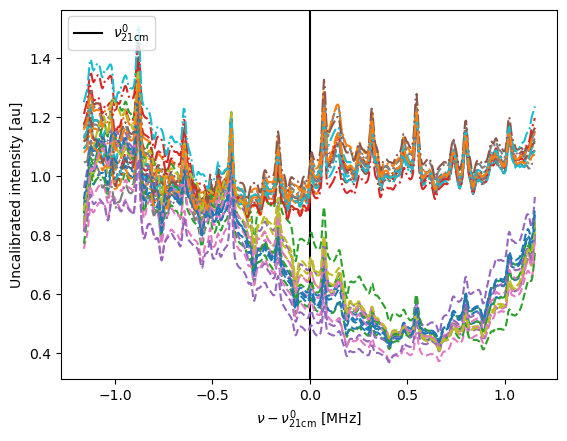

In [41]:
fig=plt.figure(0)
ax=fig.add_subplot(111)
#
ax.axvline(0., c='k', label=r'$\nu^0_\text{21cm}$')
#
for iFile in range(len(filesReduced)):
   ax.plot((fOn - nu21cm) / 1.e6, pOn[iFile,:] / pLow[iFile,:], '--')
   ax.plot((fOn - nu21cm) / 1.e6, pOn[iFile,:] / pHigh[iFile,:], '-.')
#
ax.legend(loc=2)
ax.set_xlabel(r'$\nu - \nu^0_\text{21cm}$ [MHz]')
ax.set_ylabel(r'Uncalibrated intensity [au]')
plt.show()